In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
# load the dataset from imdb
data = keras.datasets.imdb

In [3]:
# split the dataset to training and testing
(train_data, train_labels), (test_data, test_labels) = data.load_data(num_words = 88000)

/Users/meow/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/meow/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
# print out the first word
print(train_data[5])

[1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 7982, 1051, 43222, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 86588, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 15344, 10, 10]


Every word is given a machine-readable integer.

In [5]:
# k = key, v = value
word_index = data.get_word_index()

word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0 # add padding to make all the reviews the same length (same as the longest)
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown characters
word_index["<UNUSED>"] = 3

In [6]:
# reverse the words from the values back to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [7]:
# if a word is not found, "?" is used so the program does not crash
def decode_review(text):
    return "".join([reverse_word_index.get(i, "?") for i in text])

print(decode_review(test_data[6]))

<START>originallysupposedtobejustapartofahugeepictheyear1905depictingtherevolutionof1905potemkinisthestoryofthemutinyofthecrewofthepotemkininodessaharborthefilmopenswiththecrewprotestingmeatandthecaptainorderingtheexecutionoftheanuprisingtakesplaceduringwhichtherevolutionaryleaderiskilledthiscrewmanistakentotheshoretolieinstatewhenthetownspeoplegatheronahugeflightofstepsoverlookingtheharborczaristtroopsappearandmarchdownthestepsbreakingupthecrowdanavalsquadronissenttoretakethepotemkinbutatthemomentwhentheshipscomeintorangetheircrewsallowthetopassthrougheisenstein'snonhistoricallyaccurateendingisopenendedthusindicatingthatthiswastheseedofthelaterbolshevikrevolutionthatwouldbloominrussiathefilmisbrokenintofivepartsmenandmaggotsdramaontheanappealfromthedeadtheodessastepsandmeetingthesquadronbrbreisensteinwasarevolutionaryartistbutatthegeniuslevelnotwantingtomakeahistoricaldramaeisensteinusedvisualtexturetogivethefilmanewsreellooksothattheviewerfeelsheiseavesdroppingonathrillingandpolitica

In [8]:
# keep the same length (250) for both training and testing data
train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                       value = word_index["<PAD>"], padding = "post", maxlen = 250
                                                      )

test_data = keras.preprocessing.sequence.pad_sequences(test_data, 
                                                       value = word_index["<PAD>"], padding = "post", maxlen = 250
                                                      )

print(len(train_data), len(test_data))

25000 25000


In [9]:
print(len(test_data[0]), len(test_data[1]))

250 250


Building the model

In [10]:
x_val = train_labels[:5000]
x_train = train_labels[5000:]

y_val = train_labels[:5000]
y_train = train_labels[5000:]

In [11]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Embedding (88000, 16), # the embedding layer is trying to group words with similar meanings together
    layers.GlobalAveragePooling1D (), # lower the dimensions with GlobalAveragePooling1D
    layers.Dense(16, activation = 'sigmoid'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation = 'sigmoid'),
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1408000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,408,353
Trainable params: 1,408,321
Non-trainable params: 32
_____________________________________________

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # the results are either 0 or 1 (neg/pos) from the sigmoid function
    metrics = ['accuracy']
)

In [14]:
history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    batch_size = 512,
    epochs = 30,
    verbose = 2,
)

Epoch 1/30
40/40 - 1s - loss: 0.8831 - accuracy: 0.5211 - val_loss: 0.7113 - val_accuracy: 0.5092
Epoch 2/30
40/40 - 1s - loss: 0.7187 - accuracy: 0.6040 - val_loss: 0.5936 - val_accuracy: 0.5092
Epoch 3/30
40/40 - 1s - loss: 0.4828 - accuracy: 0.7696 - val_loss: 0.4023 - val_accuracy: 1.0000
Epoch 4/30
40/40 - 1s - loss: 0.2586 - accuracy: 0.9193 - val_loss: 0.2110 - val_accuracy: 1.0000
Epoch 5/30
40/40 - 1s - loss: 0.1395 - accuracy: 0.9740 - val_loss: 0.0975 - val_accuracy: 1.0000
Epoch 6/30
40/40 - 1s - loss: 0.0868 - accuracy: 0.9877 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 7/30
40/40 - 1s - loss: 0.0591 - accuracy: 0.9933 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 8/30
40/40 - 1s - loss: 0.0437 - accuracy: 0.9955 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 9/30
40/40 - 1s - loss: 0.0347 - accuracy: 0.9969 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 10/30
40/40 - 1s - loss: 0.0275 - accuracy: 0.9983 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 11/30
40/40 -

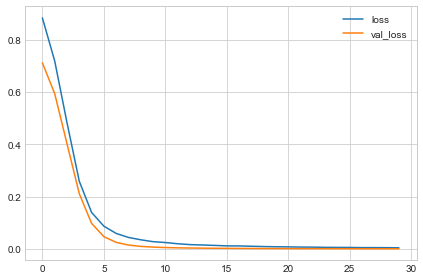

In [15]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large',
       titleweight = 'bold', titlesize = 32, titlepad = 20)

# Show the learning curves
history_data = pd.DataFrame(history.history)
history_data.loc[:, ['loss', 'val_loss']].plot();

In [16]:
results = model.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 1s 2ms/step - loss: 1.4963 - accuracy: 0.4965
[1.4962517023086548, 0.49647998809814453]


In [17]:
test_review = test_data[6]
predict = model.predict([test_review])
print('Review: ')
print(decode_review(test_review))
print('Prediction: ' + str(predict[6]))
print('Actual: '+ str(test_labels[6]))

Review: 
thestepsarefilledwithhundredsofextrasrapidanddramaticviolenceisalwayssuggestedandnotexplicityetthevisualimagesofthedeathsofafewwilllastinthemindsoftheviewerforeverbrbrtheangularshotsofmarchingbootsandlegsdescendingthestepsarecleverlyaccentuatedwithlongmenacingshadowsfromasunatthetopofthestepsthepaceofthesequenceisdeliberatelyvariedbetweenthemarchingsoldiersandafewcivilianswhosummonupcouragetobegthemtostopacloseupofawoman'sfacefrozeninhorrorafterbeingstruckbyasoldier'sswordisthedirectantecedentofthebanktellerinbonnieinclydeandgivesalastingimpressionofthehorroroftheczaristregimebrbrthedeathofayoungmotherleadstoababycarriagecareeningdownthestepsinasequencethathasbeencopiedbyhitchcockinforeigncorrespondentbyterrygilliaminbrazilandbriandepalmaintheuntouchablesthissequenceisshownrepeatedlyfromvariousanglesthusdrawingoutwhatprobablywasonlyafivesecondeventbrbrpotemkinisafilmthattherevolutionaryspiritcelebratesitforthosealreadycommittedanditfortheunconverteditseethesoffireandroarswitht